# Laboratorio de regresión logística

|                |   |
:----------------|---|
| **Nombre**     | Julia Hernández Cárdenas  |
| **Fecha**      | 04/10/2025  |
| **Expediente** | 739208  | 

La regresión logística es una herramienta utilizada para predecir respuestas cualitativas. Al igual que la regresión lineal, es un método sencillo que sirve como un punto de partida para técnicas más avanzadas. Por ejemplo, lo que se conoce como *redes neuronales* o *red de perceptrones multicapa* no es más que una estructura de regresiones logísticas que se alimentan entre sí.

1. Descarga el archivo de créditos y carga los datos (Default.csv). Utiliza `pandas`.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import t 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv("Default.csv")

2. Utiliza el comando `obj.head()`, donde `obj` es el nombre que le diste a los datos del archivo.

In [3]:
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138950
3,No,No,529.250605,35704.493940
4,No,No,785.655883,38463.495880


El comando head arroja los primeras *n* líneas (por defecto 5) de los datos que están en el DataFrame.

3. Utiliza el comando `obj.describe()`.

In [4]:
df.describe()

,balance,income
count,10000.000000,10000.000000
mean,835.374886,33516.981876
std,483.714985,13336.639563
min,0.000000,771.967729
25%,481.731105,21340.462903
50%,823.636973,34552.644802
75%,1166.308386,43807.729275
max,2654.322576,73554.233500


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


El comando describe toma las columnas que tienen datos numéricos y saca datos estadísticos comunes:
- *n*
- media
- desviación estándar
- valor mínimo
- primer cuartil
- mediana
- tercer cuartil
- valor máximo

**3. Vistos estos datos, ¿qué columnas existen en el DataFrame? ¿Qué tipo de datos contienen?**

La columna tiene 4 columnas: "Default", "student", "balance" y "income". Las primeras dos columnas tienen objetos, "yes" o "no", mientras que las últimas dos columnas tienen valores numéricos. 

4. Configura el tipo de dato de las columnas `default` y `student` para cambiarlos a variables categóricas.

`data[columna] = data[columna].astype("category")`

In [6]:
df["default"] = df["default"].astype("category")

In [7]:
df["student"] = df["student"].astype("category")

Imagina que trabajas en un banco y que se te entregan estos datos. Tu objetivo es crear un modelo que ayude a predecir si una persona que solicita un crédito lo va a pagar. Exploremos los datos un poco más antes de crear un modelo.

Veamos primero cómo es la distribución de los valores cuando una persona dejó de pagar y cuando siguió pagando. `Default` es el término utilizado para cuando una persona dejó de pagar.

5. Crea una gráfica de caja para las columnas `income` y `balance`, con los datos agrupados con la columna `default`. Utiliza el comando `obj.boxplot(column=____, by=_____)`

<Axes: title={'center': 'balance'}, xlabel='default'>

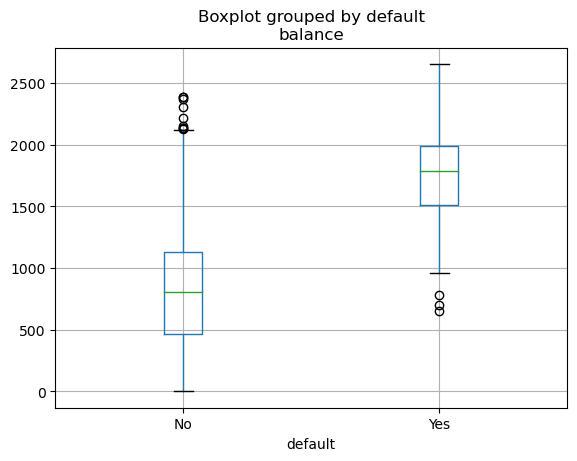

In [8]:
df.boxplot(column="balance", by="default")

<Axes: title={'center': 'income'}, xlabel='default'>

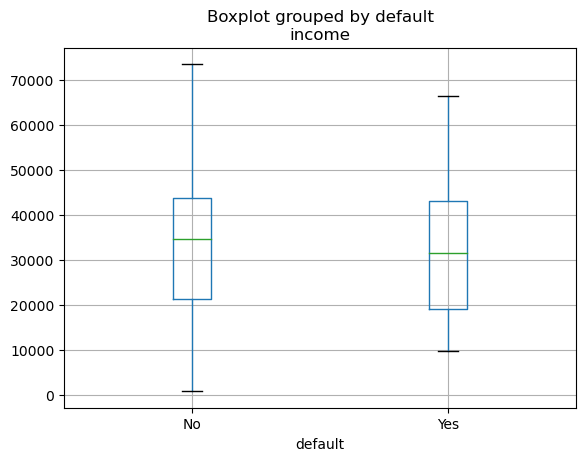

In [9]:
df.boxplot(column="income", by="default")

6. Crea una gráfica de dispersión donde el eje *x* sea la columna `balance` y el eje *y* la columna `income`. Utiliza el comando `obj.plot.scatter(x, y, c="default", colormap="PiYG_r", alpha=0.5)`.

<Axes: xlabel='balance', ylabel='income'>

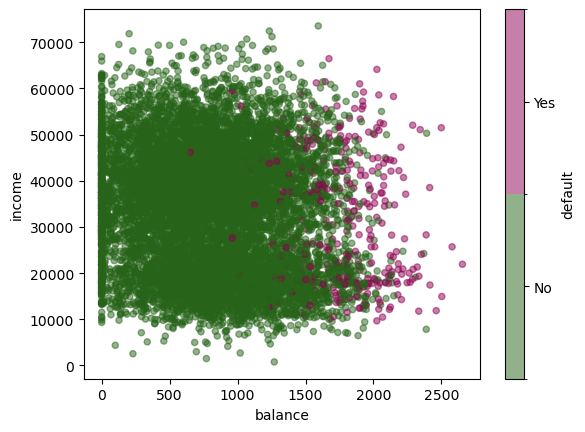

In [10]:
df.plot.scatter(x = "balance", y = "income", c="default", colormap="PiYG_r", alpha=0.5)

La regresión (lineal o logística) se usa para encontrar una línea que ajuste los datos para tomar una decisión. La línea que buscamos en regresión logística es aquella que nos ayude a separar las diferentes categorías. 

<img style="float: left; " src="https://www.baeldung.com/wp-content/uploads/sites/4/2023/10/decision_boundary_curve.jpg" width="400px" />


## Regresión logística simple

Creemos un modelo simple donde sólo utilizamos una de los factores para predecir una respuesta. Quiero conocer la probabilidad de que una persona deje de pagar su crédito dado el balance que tiene en su cuenta.

$$ P(\text{default}=\text{Yes}|\text{balance}) $$

Por el momento la columna default no contiene valores numéricos, por lo que hay que transformar los datos. Como default es nuestra variable de respuesta (lo que queremos predecir) podemos nombrarla *y*.

Ejecuta el código `y = obj["default"] == "Yes"`. Extrae el factor `balance` en una variable *x*.

In [11]:
y = df["default"] == "Yes"

In [12]:
x = df["balance"]

Crea un gráfico de dispersión donde el eje *x* sea `balance` y el eje *y* sea `default` transformado.

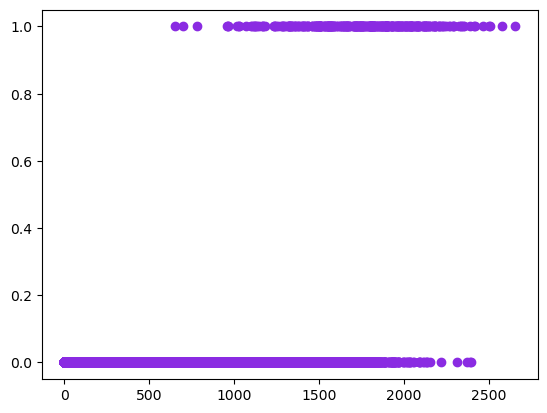

In [13]:
plt.scatter(x, y, color = "blueviolet")

La línea que utilizaremos para predecir la probabilidad es:

$$ p(x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x)}} $$

Para nuestro ejemplo de pagos y balance:

$$ P(\text{default}=1|\text{balance}) = \frac{1}{1 + e^{-(\beta_0 + \beta_1  \text{balance})}} $$

Buscamos maximizar la probabilidad de que el modelo tome decisiones correctas. Es decir, que cuando `default` fue verdadero, que la predicción sea 100%, y que cuando `default` fue falso que la predicción sea 0%.

$$ \Pi_{i:y_i=1} p(x_i) \Pi_{i':y_{i'}} (1-p(x_{i'})) $$

La función de costo ya simplificada es la siguiente:

$$ J(\vec{\beta}) = -  \sum_{i=1}^n{[y_i \ln{(\hat{p}(x_i))} + (1-y_i)\ln{(1 - \hat{p}(x_i))}]}$$

Utiliza la clase `LogisticRegression` del módulo `linear_model` de la librería `sklearn` para estimar los parámetros del modelo.

In [14]:
x = x.values.reshape(-1, 1) 

modelo = LogisticRegression()
modelo.fit(x, y)

LogisticRegression()

Muchos aspectos de la regresión logística son similares a la regresión lineal. Podemos medir la precisión de nuestros estimados calculando sus errores estándar. El objetivo de calcular estos errores es asegurar que hay una relación estadísticamente significativa entre el factor y la variable de respuesta.

Los errores estándar se obtienen con el siguiente procedimiento:

1. Calcula las predicciones utilizando los $\beta_0$ y $\beta_1$ encontrados.

In [15]:
B0 = modelo.intercept_
B0

array([-10.65132824])

In [16]:
B1 = modelo.coef_
B1

array([[0.00549892]])

In [17]:
beta = B0 + B1 * x

In [18]:
p = 1 / (1 + np.exp(-beta))
p

array([[1.30568146e-03],
       [2.11259754e-03],
       [8.59474814e-03],
       ...,
       [2.46651596e-03],
       [1.16759635e-01],
       [7.14476480e-05]])

2. Idealmente la probabilidad debería ser 100% o 0%. Si alguna predicción no fue absoluta significa que hay incertidumbre. Calcula $p(1-p)$ para todas tus predicciones.

In [19]:
p2 = p*(1+p)
p2

array([[1.30738626e-03],
       [2.11706061e-03],
       [8.66861783e-03],
       ...,
       [2.47259966e-03],
       [1.30392447e-01],
       [7.14527527e-05]])

3. Crea una matriz vacía y llena la diagonal con las probabilidades encontradas.

`V = np.diagflat(*p(1-p)*)`

In [20]:
V = np.diagflat(p * (1 - p))

4. Calcula la matriz de covarianza. (Dado que X es la matriz que contiene todos los factores)

`cov = np.linalg.inv(X.T @ V @ X)`

In [21]:
cov = np.linalg.inv(x.T @ V @ x)
cov

array([[1.71411499e-09]])

5. Los valores en la diagonal de la matriz de covarianza corresponden a la varianza de los factores. Utiliza los valores de la diagonal para calcular el error estándar.

`se = np.sqrt(np.diag(cov))`

In [22]:
se = np.sqrt(np.diag(cov))
se

array([4.14018718e-05])

Ahora, revisemos si los estimados de nuestros coeficientes demuestran que hay una relación significativa entre los factores y la respuesta.

Calculamos el estadístico *z*

$$ z_j = \frac{\hat{\beta_j}}{\text{SE}(\hat{\beta_j})} $$

In [23]:
z = B1 / se
z

array([[132.81804209]])

Utilizamos el estadístico *z* para encontrar el *p-value*.

`from scipy.stats import norm`

`p_value = 2 * (1 - norm.cdf(abs(z_statistic)))`

In [24]:
from scipy.stats import norm

In [25]:
p_value = 2 * (1 - norm.cdf(abs(z)))
p_value

array([[0.]])

**¿Es significativa la relación de los factores con la variable de respuesta?**

Podría decirse que si es significativa, ya que su p-value (=0) es < 0.05

Repite el procedimiento con el factor `student`. 
1. Transforma el factor de {"Yes", "No"} a {1, 0}.
2. Estima los coeficientes. 
3. Calcula el error estándar de tus estimaciones.
   1. Usa tu modelo para encontrar $\hat{p}(X)$
   2. Calcula el error $p(1-p)$
   3. Calcula la matriz de covarianza
   4. Extrae el error estándar
5. Argumenta si los factores son significativos utilizando el *p-value*.
   1. Utiliza el error estándar para calcular el estadístico *z*
   2. Calcula el *p-value*
   3. ¿Son significativos?


In [26]:
x_student = df["student"] == "Yes"

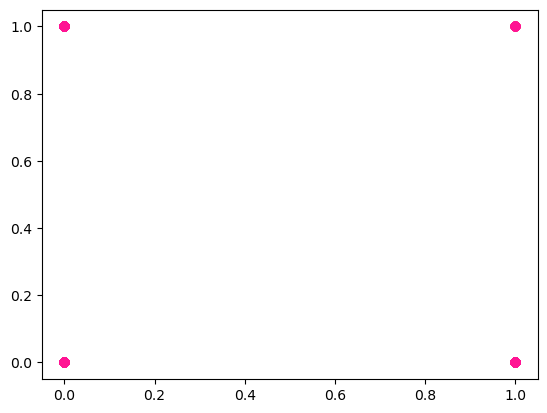

In [27]:
plt.scatter(x_student, y, alpha=0.5, color = 'deeppink')

In [28]:
x_student = x_student.values.reshape(-1, 1) 

modelo_student = LogisticRegression()
modelo_student.fit(x_student, y)

LogisticRegression()

In [29]:
B0_student = modelo_student.intercept_
B0_student

array([-3.50213253])

In [30]:
B1_student = modelo_student.coef_
B1_student

array([[0.39960123]])

In [31]:
beta_student = B0_student + B1_student * x_student

In [32]:
p_student = 1 / (1 + np.exp(-beta_student))
p_student

array([[0.02925161],
       [0.04300296],
       [0.02925161],
       ...,
       [0.02925161],
       [0.02925161],
       [0.04300296]])

In [33]:
p2_student = p_student * ( 1 + p_student)
p2_student

array([[0.03010727],
       [0.04485222],
       [0.03010727],
       ...,
       [0.03010727],
       [0.03010727],
       [0.04485222]])

In [34]:
V_student = np.diagflat(p_student * (1 - p_student))

In [35]:
cov_student = np.linalg.inv(x_student.T @ V @ x_student)

In [36]:
se_student = np.sqrt(np.diag(cov_student))

In [37]:
z_student = B1_student / se_student

In [38]:
p_value_student = 2 * (1 - norm.cdf(abs(z_student)))
p_value_student

array([[8.46058629e-05]])

Como el p-value es igual a 0 (y por ende < 0.05) se puede decir que esta variable si es significativa

## Regresión logística múltiple

Considera ahora el caso de múltiples factores. Intentemos predecir si la persona dejará de pagar su crédito utilizando toda la información que tenemos disponible. I.e.

$$ P(\text{default}=1|\text{balance}, \text{income}, \text{student}) = \frac{1}{1 + e^{-(\beta_0 + \beta_1  \text{balance} + \beta_2 \text{income} + \beta_3 \text{student})}} $$

1. Utiliza `LogisticRegression` para estimar los coeficientes.
2. Calcula el error estándar de tus estimaciones.
3. Argumenta si los factores son significativos utilizando el *p-value*. 

In [39]:
x_todo = df[['balance', 'income', 'student']]

In [40]:
x_todo = pd.get_dummies(x_todo, columns=['student'], drop_first=True)
x_todo = x_todo.astype(np.float64)

modelo_todo = LogisticRegression()
modelo_todo.fit(x_todo, y)

LogisticRegression()

In [41]:
B0_todo = modelo_todo.intercept_
B0_todo

array([-2.9508496])

In [42]:
B1_todo = modelo_todo.coef_
B1_todo

array([[ 4.08201022e-03, -1.33893466e-04, -3.89009045e+00]])

In [43]:
beta_todo = B0_todo + np.dot(x_todo, B1_todo.T)
p_todo = 1 / (1 + np.exp(-beta_todo))
p_todo

array([[0.00269772],
       [0.00590441],
       [0.05614562],
       ...,
       [0.00064162],
       [0.18909626],
       [0.00025382]])

In [44]:
p2_todo = 1 - p_todo
p2_todo

array([[0.99730228],
       [0.99409559],
       [0.94385438],
       ...,
       [0.99935838],
       [0.81090374],
       [0.99974618]])

In [45]:
V_todo = np.diagflat(p_todo * (1 - p_todo))

In [46]:
cov_todo = np.linalg.inv(x_todo.T @ V_todo @ x_todo)
cov_todo

array([[ 2.17585078e-08, -8.51709190e-10, -2.24568464e-05],
       [-8.51709190e-10,  3.75727292e-11,  8.10405362e-07],
       [-2.24568464e-05,  8.10405362e-07,  3.84972968e-02]])

In [47]:
se_todo = np.sqrt(np.diag(cov_todo))
se_todo

array([1.47507653e-04, 6.12965979e-06, 1.96207280e-01])

In [48]:
z_todo = B1_todo / se_todo
z_todo 

array([[ 27.67320966, -21.84353945, -19.82643274]])

In [49]:
p_value_todo = 2 * (1 - norm.cdf(np.abs(z_todo)))
p_value_todo

array([[0., 0., 0.]])

Como todos los p-values son iguales a 0, se puede argumentar que todos los factores son significativos para calcular la variable "y"

¿Cómo sabemos qué tan bueno es el modelo? Hay cuatro posibles casos para un problema de clasificación simple:
- Era sí y se predijo sí. (Verdadero positivo **TP**)
- Era sí y se predijo no. (Falso negativo **FN**)
- Era no y se predijo sí. (Falso positivo **FP**)
- Era no y se predijo no. (Verdadero negativo **TN**)

De esos cuatro casos hay dos donde el modelo es correcto y dos donde el modelo no es correcto.

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*IuymDnZpRlkat0qejE26Nw.png)

**Menciona dos ejemplos donde consideres que un falso positivo sea un peor resultado que un falso negativo.**

1. Cuando se condena para carcel a una persona que en realidad es inocente

2. En pruebas deportivas, cuando se detecta uso de alguna droga en el atleta cuando en realidad no había consumido nada 

**Menciona dos ejemplos donde consideres que un falso negativo sea un peor resultado que un falso positivo.**

1. En un embarazo no deseado, si una prueba aparece como negativa cuando en realidad es positiva. Quitándole tiempo a la madre de poder tomar alguna decisión 

2. En control de calidad, cuando se aprueba un lote que en realidad está defectuoso

## Referencia

James, G., Witten, D., Hastie, T., Tibshirani, R.,, Taylor, J. (2023). An Introduction to Statistical Learning with Applications in Python. Cham: Springer. ISBN: 978-3-031-38746-3